## 目录

1. 引言

   1.1 任务目标

   1.2 数据集介绍

2. 实验环境与配置

3. 数据准备与预处理

   3.1 导入必要的库
   
   3.2 下载与解压数据集

   3.3 读取数据集

   3.4 数据集分析与可视化

   3.5 Tokenization与Padding

   3.6 创建PyTorch Dataset和DataLoader

4. 模型构建

   4.1 BERT模型简介

   4.2 定义情感分类模型

5. 模型训练

   5.1 定义损失函数和优化器

   5.2 定义训练和评估函数

       训练函数
       评估函数

   5.3 开始训练

   5.4 训练过程可视化

6. 模型评估

   6.1 在测试集上评估

   6.2 混淆矩阵和分类报告
   
       混淆矩阵
       分类报告
       测试结果解读 

7. 实例评估

   7.1 定义预测函数

   7.2 执行预测

   7.3 预测示例句子

   7.4 小结

8. 总结与展望


## 1. 引言

### 1.1 任务目标

本次作业旨在利用序列神经网络（如 RNN、Transformer 或 BERT）对 IMDB 电影评论数据集进行情感分类。情感识别是自然语言处理（NLP）中的经典任务，目标是判断文本所表达的情绪倾向。在本任务中，我们将评论划分为“积极”（positive）和“消极”（negative）两类，重点探索深度学习模型在二分类情感分析中的应用效果。

### 1.2 数据集介绍

本次实验使用的数据集是由斯坦福大学发布的 Large Movie Review Dataset（大型电影评论数据集），由 Andrew Maas 等人整理，广泛用于情感分析和文本分类研究。该数据集来源于 IMDB 网站，包含共 50,000 条英文电影评论，均已人工标注为“正面”或“负面”情感。

数据集被平均划分为训练集和测试集，各包含 25,000 条评论，且正负样本数量平衡（各 12,500 条）。训练集中不包含测试集中的评论，确保模型评估的独立性和客观性。

除了上述标注数据外，数据集中还提供了额外的 50,000 条未标注评论（存储在训练集的 `unsup/` 文件夹中），可用于无监督或半监督学习任务。

IMDB数据集的数据以纯文本形式存储，按情感标签分为 `pos/` 和 `neg/` 两个子目录，每条评论对应一个 `.txt` 文件。原始文本中包含一定的 HTML 标记，需在预处理阶段进行清洗。该数据集可通过斯坦福官网免费获取，下载链接为：  
[http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/)

该数据集因其规模大、标签明确、结构清晰，成为情感分析研究中的标准基准集，常用于比较和评估不同文本分类算法的性能。尽管如此，它也存在一些局限性，例如：  
- 评论仅限英文，无法直接用于多语言任务；  
- 缺乏额外的上下文信息（如用户、电影元数据等）；  
- 来源单一，可能存在平台偏见。

总之，Large Movie Review Dataset 是一个经典且实用的情感分析数据集，适合用于深度学习模型训练与评估。合理地对其进行清洗和处理，有助于提高模型的泛化能力和分析效果。

## 2. 实验环境与配置

本次作业在一台高性能台式计算机上进行实验，该机器的具体的硬件和软件配置如下：

*   **处理器**: Intel Core i9-14900K (32 核, 主频约 3.2GHz, 可睿频至更高)
*   **内存**: 64GB DDR5 RAM
*   **存储**:
    *   Samsung SSD 990 PRO 2TB （用于系统与项目代码）
    *   ST8000NM017B 8TB HDD （用于数据集及大文件存储）
*   **操作系统**: Windows 11 专业版
*   **Python环境管理**: Anaconda3
    *   **Conda虚拟环境**: `DL39`
    *   **Python版本**: 3.9.21
*   **主要开发工具**: 
    *   **Jupyter Notebook**（通过 Anaconda Navigator 启动）
    *   **Visual Studio Code**（辅助编辑与调试）
*   **主要Python库版本**:
    *   `torch`: 2.6.0 (GPU版本)
    *   `transformers`: 4.51.3
    *   `numpy`: 1.23.5
    *   `matplotlib`: 3.7.2
    *   `pandas`: 2.0.3 (虽然本次作业不一定直接用Pandas处理文本，但它是数据分析常用库)
    *   `scikit-learn`: 用于评估指标(如混淆矩阵、分类报告)
    *   `tqdm`: 用于显示进度条
    *   `requests`: 用于下载数据
*   **GPU与CUDA**:
    *   **GPU型号**: NVIDIA GeForce RTX 4080 SUPER
    *   **显存**: 16GB GDDR6X
    *   **NVIDIA驱动程序版本**: 561.09 (或更新版本)
    *   **CUDA Toolkit版本**: 12.6 (与PyTorch兼容的最新版本)
    *   **cuDNN版本**: 随CUDA Toolkit安装，与PyTorch兼容

该配置为深度学习任务提供了充足的计算资源，特别是配备 RTX 4080 SUPER GPU，在处理 BERT 等大型模型时具备优异的训练效率。64GB 系统内存亦保障了大规模数据预处理与模型加载的顺畅执行。

## 3. 数据准备与预处理

在进行模型训练之前，我将首先需要完成必要的准备工作，包括导入依赖库、设置运行环境、定义超参数等内容。为了充分利用预训练模型的优势，将采用 HuggingFace 的 Transformers 库，并使用其提供的 `bert-base-uncased` 模型作为文本编码器。

### 3.1 导入必要的库并设置运行参数

以下代码块中导入了本次任务所需的所有库，涵盖数据处理、模型训练、性能评估和可视化等方面。另外，为了提高代码的可维护性和清晰度，我将常用的文件路径和模型超参数预先定义为全局变量，便于后续调用与修改。

In [1]:
# 系统与文件处理相关库
import os
import shutil        # 用于操作文件夹（如删除已存在的目录）
import tarfile       # 用于解压 .tar.gz 格式的数据压缩包
import requests      # 用于从网络下载数据文件
from tqdm import tqdm # 用于显示下载与训练的进度条

# 深度学习相关库（PyTorch 和 Transformers）
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

# 数据分析与评估工具库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # 用于更美观的图形绘制
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 设置 Matplotlib 参数以支持中文显示（适用于生成中文图表）
plt.rcParams['font.sans-serif'] = ['SimHei']        # 指定默认字体为“黑体”
plt.rcParams['axes.unicode_minus'] = False          # 解决负号显示为乱码的问题

# 检测是否可用GPU设备，如不可用则使用CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {DEVICE}")


# 定义一些全局变量

# 数据集下载地址与文件名
DATA_URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
DATA_ARCHIVE_NAME = 'aclImdb_v1.tar.gz'
DATA_EXTRACTED_DIR_NAME = 'aclImdb'

# 本地路径设置
BASE_DATA_DIR = './data'                                # 所有数据的根目录
BASE_MODEL_DIR = './models'                             # 模型保存目录
IMDB_DATA_DIR = os.path.join(BASE_DATA_DIR, DATA_EXTRACTED_DIR_NAME)  # 解压后IMDB数据所在目录

# 预训练BERT模型名称（使用 HuggingFace 的模型标识符）
BERT_MODEL_NAME = 'bert-base-uncased'

# 模型训练的超参数设置
MAX_LEN = 512         # BERT 支持的最大输入长度为512 tokens
BATCH_SIZE = 16       # 批大小，可根据显卡显存适当调整；4080 SUPER 一般可支持16或更大
EPOCHS = 5            # 中型数据集（如1万~10万条样本），微调BERT时通常训练2~5轮即可取得良好效果
LEARNING_RATE = 2e-5  #  BERT微调常用学习率

使用的设备: cuda


### 3.2 下载与解压数据集

接下来，需要下载IMDB数据集并将其解压到指定目录。这里，我将实现一个函数 `download_and_extract` 来完成这个任务，该函数会检查数据是否已存在，避免重复下载。

In [2]:
def download_and_extract(url, archive_name, extracted_dir_name, base_dir):
    """
    下载并解压数据集。

    参数:
    url (str): 数据集的下载链接。
    archive_name (str): 下载的压缩文件名。
    extracted_dir_name (str): 解压后数据的主文件夹名。
    base_dir (str): 数据存放的根目录。

    返回:
    str: 解压后数据的完整路径。
    """
    # 确保基础数据目录存在
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
        print(f"创建目录: {base_dir}")

    data_path = os.path.join(base_dir, extracted_dir_name)
    archive_path = os.path.join(base_dir, archive_name)

    # 如果解压后的数据目录已存在，则直接返回路径
    if os.path.exists(data_path):
        print(f"数据集已存在于: {data_path}")
        return data_path

    # 如果压缩文件不存在，则下载
    if not os.path.exists(archive_path):
        print(f"开始下载数据集从 {url} 到 {archive_path}...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status() # 如果请求失败则抛出HTTPError
            total_size = int(response.headers.get('content-length', 0))
            
            with open(archive_path, 'wb') as f, tqdm(
                desc=archive_name,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=1024):
                    size = f.write(data)
                    bar.update(size)
            print(f"数据集下载完成: {archive_path}")
        except requests.exceptions.RequestException as e:
            print(f"下载失败: {e}")
            if os.path.exists(archive_path): # 如果下载不完整，删除文件
                os.remove(archive_path)
            return None
    else:
        print(f"压缩文件已存在: {archive_path}")

    # 解压文件
    print(f"开始解压 {archive_path} 到 {base_dir}...")
    try:
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path=base_dir)
        print(f"数据集解压完成到: {data_path}")
        # 解压后，aclImdb_v1.tar.gz会解压出一个名为aclImdb的文件夹，这与extracted_dir_name一致
    except tarfile.TarError as e:
        print(f"解压失败: {e}")
        # 如果解压失败，可能需要清理已解压的部分，但tarfile通常是原子性的或覆盖的
        if os.path.exists(data_path):
             # 如果解压不完全或损坏，最好删除已解压的目录
            shutil.rmtree(data_path)
            print(f"已删除损坏的解压目录: {data_path}")
        return None
    
    return data_path

# 执行下载和解压
# 注意：此处IMDB_DATA_DIR是期望的解压后目录名，download_and_extract函数内部会处理
# DATA_EXTRACTED_DIR_NAME 应该是 'aclImdb'
imdb_data_dir_actual = download_and_extract(DATA_URL, DATA_ARCHIVE_NAME, DATA_EXTRACTED_DIR_NAME, BASE_DATA_DIR)

if imdb_data_dir_actual:
    print(f"数据集准备就绪于: {imdb_data_dir_actual}")
else:
    print("数据集准备失败，请检查网络连接或手动下载解压。")
    # 如果失败，后续代码可能无法运行，这里可以考虑退出或抛出异常
    # exit()

创建目录: ./data
开始下载数据集从 http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 到 ./data\aclImdb_v1.tar.gz...


aclImdb_v1.tar.gz: 100%|██████████| 80.2M/80.2M [02:57<00:00, 475kiB/s] 


数据集下载完成: ./data\aclImdb_v1.tar.gz
开始解压 ./data\aclImdb_v1.tar.gz 到 ./data...
数据集解压完成到: ./data\aclImdb
数据集准备就绪于: ./data\aclImdb


### 3.3 读取数据集

数据集包含训练和测试两部分，每部分又分为积极（pos）和消极（neg）两类评论。我将实现 `read_imdb` 函数来读取这些文本文件和对应的标签。

In [3]:
def read_imdb(data_dir, is_train):
    """
    读取IMDb评论数据集文本序列和标签。

    参数:
    data_dir (str): 解压后的IMDb数据集根目录 (例如 './data/aclImdb')。
    is_train (bool): True表示读取训练集，False表示读取测试集。

    返回:
    tuple: (texts, labels)，texts是评论列表，labels是对应的标签列表 (0 for neg, 1 for pos)。
    """
    texts, labels = [], []
    data_type = 'train' if is_train else 'test'
    
    for label_type in ('pos', 'neg'):
        folder_path = os.path.join(data_dir, data_type, label_type)
        if not os.path.exists(folder_path):
            print(f"警告: 目录 {folder_path} 不存在。")
            continue
            
        print(f"正在读取 {folder_path} 中的文件...")
        for filename in tqdm(os.listdir(folder_path), desc=f"读取 {label_type} 评论 ({data_type})"):
            if filename.endswith('.txt'):
                file_path = os.path.join(folder_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        # 移除换行符，特别是HTML的<br />标签，通常被视为空格
                        review_text = f.read().replace('<br />', ' ').replace('\n', ' ').strip()
                        texts.append(review_text)
                        labels.append(1 if label_type == 'pos' else 0)
                except Exception as e:
                    print(f"读取文件 {file_path} 时出错: {e}")
    
    return texts, labels

# 确保imdb_data_dir_actual是有效的路径
if imdb_data_dir_actual and os.path.exists(imdb_data_dir_actual):
    train_texts, train_labels = read_imdb(imdb_data_dir_actual, is_train=True)
    test_texts, test_labels = read_imdb(imdb_data_dir_actual, is_train=False)

    print(f"\n训练集样本数: {len(train_texts)}")
    print(f"测试集样本数: {len(test_texts)}")

    # 打印前几个样本看看
    if len(train_texts) > 0:
        print("\n训练集样本示例:")
        for i in range(min(3, len(train_texts))):
            print(f"标签: {'积极' if train_labels[i] == 1 else '消极'}, 评论 (前100字符): {train_texts[i][:100]}")
    if len(test_texts) > 0:
        print("\n测试集样本示例:")
        for i in range(min(3, len(test_texts))):
            print(f"标签: {'积极' if test_labels[i] == 1 else '消极'}, 评论 (前100字符): {test_texts[i][:100]}")
else:
    print("IMDb数据目录未正确设置或不存在，无法读取数据。")
    # 为避免后续代码出错，可以设置空列表
    train_texts, train_labels = [], []
    test_texts, test_labels = [], []


正在读取 ./data\aclImdb\train\pos 中的文件...


读取 pos 评论 (train): 100%|██████████| 12500/12500 [00:01<00:00, 9367.85it/s]


正在读取 ./data\aclImdb\train\neg 中的文件...


读取 neg 评论 (train): 100%|██████████| 12500/12500 [00:01<00:00, 8973.82it/s]


正在读取 ./data\aclImdb\test\pos 中的文件...


读取 pos 评论 (test): 100%|██████████| 12500/12500 [00:01<00:00, 8846.91it/s]


正在读取 ./data\aclImdb\test\neg 中的文件...


读取 neg 评论 (test): 100%|██████████| 12500/12500 [00:01<00:00, 7036.51it/s]


训练集样本数: 25000
测试集样本数: 25000

训练集样本示例:
标签: 积极, 评论 (前100字符): Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life,
标签: 积极, 评论 (前100字符): Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan
标签: 积极, 评论 (前100字符): Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scene

测试集样本示例:
标签: 积极, 评论 (前100字符): I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that
标签: 积极, 评论 (前100字符): Actor turned director Bill Paxton follows up his promising debut, the Gothic-horror "Frailty", with 
标签: 积极, 评论 (前100字符): As a recreational golfer with some knowledge of the sport's history, I was pleased with Disney's sen


### 3.4 数据集分析与可视化

在进行Tokenization之前，先要对原始文本的长度进行一些分析。这将帮助我确定一个合适的 `MAX_LEN`（最大序列长度）。虽然已经为BERT模型预设了 `MAX_LEN = 512`，但了解数据的实际长度分布仍然是有益的。

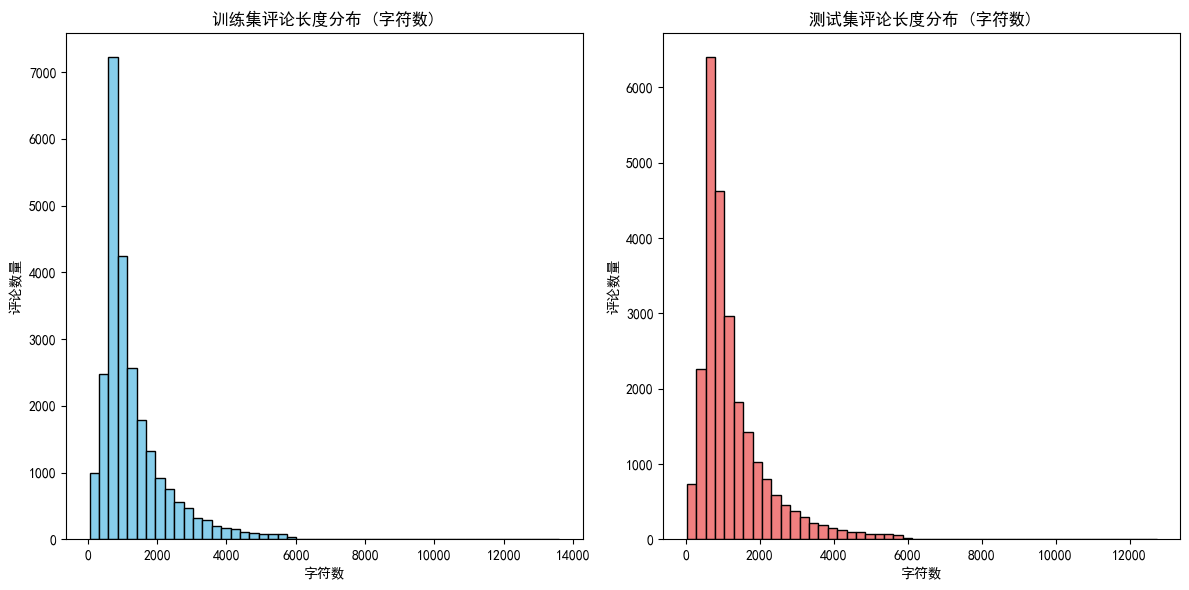

训练集评论平均字符长度: 1304.65
训练集评论字符长度中位数: 965.00
训练集评论最大字符长度: 13602


In [4]:
if train_texts: # 确保train_texts不是空的
    # 计算每条评论的原始文本长度（字符数）
    train_text_lengths = [len(text) for text in train_texts]
    test_text_lengths = [len(text) for text in test_texts]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(train_text_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title('训练集评论长度分布 (字符数)')
    plt.xlabel('字符数')
    plt.ylabel('评论数量')

    plt.subplot(1, 2, 2)
    plt.hist(test_text_lengths, bins=50, color='lightcoral', edgecolor='black')
    plt.title('测试集评论长度分布 (字符数)')
    plt.xlabel('字符数')
    plt.ylabel('评论数量')

    plt.tight_layout()
    plt.show()

    print(f"训练集评论平均字符长度: {np.mean(train_text_lengths):.2f}")
    print(f"训练集评论字符长度中位数: {np.median(train_text_lengths):.2f}")
    print(f"训练集评论最大字符长度: {np.max(train_text_lengths)}")
    
    # 查看超过BERT默认最大Token数（约等于字符数）的评论比例
    # BERT的token数通常少于字符数，但这里用字符数粗略估计
    # 512 tokens 大约对应 1500-2000 字符，取决于语言和分词。
    # BERT的输入是token序列，而非字符序列，所以这个分析是初步的。
    # 后面我们会用BERT tokenizer分析token长度。
else:
    print("训练数据为空，无法进行长度分析。")

从字符长度分布来看，大部分评论的字符数都在几千以内。BERT模型处理的是Token序列，一个Token通常对应一个词或子词。接下来，我将使用BERT的Tokenizer对文本进行分词，并分析Token序列的长度。

### 3.5 Tokenization与Padding

我将使用HuggingFace Transformers库中提供的 `BertTokenizerFast`。这个分词器会将文本转换成BERT模型能够理解的格式，包括：

1.  **Tokenize**: 将文本分割成tokens（词或子词）。
2.  **Add Special Tokens**: 在序列开头添加 `[CLS]`（分类标志）和结尾添加 `[SEP]`（分隔标志）。
3.  **Convert to IDs**: 将tokens映射到它们在BERT词汇表中的ID。
4.  **Padding**: 将所有序列填充到相同的长度（`MAX_LEN`）。
5.  **Attention Mask**: 创建一个attention mask，用于指示哪些token是真实内容，哪些是填充。


分词器输出示例:
Input IDs: tensor([  101, 22953,  2213,  4381,  2152,  2003,  1037,  9476,  4038,  1012,
         2009,  2743,  2012,  1996,  2168,  2051,  2004,  2070,  2060,  3454])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Decoded tokens: ['[CLS]', 'bro', '##m', '##well', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs']

正在对训练集进行分词 (仅用于长度分析)...


Tokenizing Train: 100%|██████████| 25000/25000 [00:08<00:00, 2898.84it/s]



正在对测试集进行分词 (仅用于长度分析)...


Tokenizing Test: 100%|██████████| 25000/25000 [00:08<00:00, 2954.56it/s]


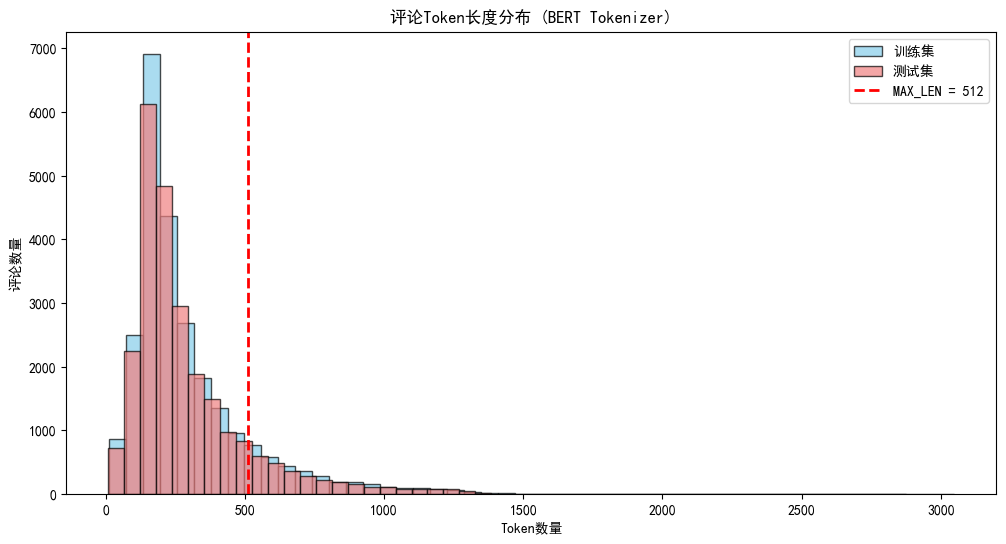

训练集中有 3319/25000 (13.28%) 条评论Token长度超过 512
测试集中有 3086/25000 (12.34%) 条评论Token长度超过 512


In [5]:
# 加载BERT分词器
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

# 示例：对一条评论进行分词
if train_texts:
    sample_text = train_texts[0]
    encoded_sample = tokenizer(sample_text, max_length=MAX_LEN, truncation=True, padding='max_length', return_tensors='pt')
    print("\n分词器输出示例:")
    print("Input IDs:", encoded_sample['input_ids'][0, :20]) # 只显示前20个ID
    print("Attention Mask:", encoded_sample['attention_mask'][0, :20]) # 只显示前20个mask
    # token_type_ids对于单句分类任务通常全为0，这里可以不特别关注
    print("Decoded tokens:", tokenizer.convert_ids_to_tokens(encoded_sample['input_ids'][0, :20]))


# 对所有训练和测试数据进行分词和编码
# 为了分析token长度分布，我先不padding，只truncation
if train_texts and test_texts:
    print("\n正在对训练集进行分词 (仅用于长度分析)...")
    train_token_lengths = [len(tokenizer.encode(text, max_length=5000, truncation=True)) for text in tqdm(train_texts, desc="Tokenizing Train")]
    
    print("\n正在对测试集进行分词 (仅用于长度分析)...")
    test_token_lengths = [len(tokenizer.encode(text, max_length=5000, truncation=True)) for text in tqdm(test_texts, desc="Tokenizing Test")]

    plt.figure(figsize=(12, 6))
    plt.hist(train_token_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='训练集')
    plt.hist(test_token_lengths, bins=50, color='lightcoral', edgecolor='black', alpha=0.7, label='测试集')
    plt.axvline(MAX_LEN, color='red', linestyle='dashed', linewidth=2, label=f'MAX_LEN = {MAX_LEN}')
    plt.title('评论Token长度分布 (BERT Tokenizer)')
    plt.xlabel('Token数量')
    plt.ylabel('评论数量')
    plt.legend()
    plt.show()

    # 计算有多少评论的Token长度超过MAX_LEN
    train_longer_than_max = sum(1 for length in train_token_lengths if length > MAX_LEN)
    test_longer_than_max = sum(1 for length in test_token_lengths if length > MAX_LEN)
    print(f"训练集中有 {train_longer_than_max}/{len(train_texts)} ({(train_longer_than_max/len(train_texts))*100:.2f}%) 条评论Token长度超过 {MAX_LEN}")
    print(f"测试集中有 {test_longer_than_max}/{len(test_texts)} ({(test_longer_than_max/len(test_texts))*100:.2f}%) 条评论Token长度超过 {MAX_LEN}")

    # 从Token长度分布图和统计数据可以看出，MAX_LEN=512会截断一部分较长的评论。
    # 这是使用BERT模型时常见的权衡，因为其最大输入长度通常是512。
    # 对于情感分析任务，评论的关键信息通常出现在文本的开头或结尾，因此截断可能仍能保留足够的情感信号。
else:
    print("训练或测试数据为空，无法进行Token长度分析。")

从 Token 长度分布图可以看出，虽然设置 `MAX_LEN = 512` 会导致部分文本被截断，但大多数评论的长度仍在可接受范围内。对于情感分析任务而言，情感倾向通常能够通过评论的前几段文字有效识别，因此适当的截断不会显著影响模型性能。

此外，由于 BERT 架构本身的输入长度上限为 512，这是当前大多数 BERT 应用中的标准配置。综合考虑模型能力与计算资源，我决定采用 `MAX_LEN = 512` 作为最终的输入长度。

接下来，我将对数据进行编码处理，以便输入模型进行训练。

In [6]:
def encode_texts(tokenizer, texts, max_len):
    """
    使用tokenizer对文本列表进行编码。
    返回input_ids, attention_mask。
    """
    print(f"正在使用Tokenizer编码文本，max_len={max_len}...")
    # tokenizer会自动处理padding和truncation
    # return_attention_mask=True 是默认的
    # padding='max_length' 会填充到max_len
    # truncation=True 会截断超过max_len的部分
    # return_tensors='pt' 返回PyTorch张量
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

if train_texts and test_texts:
    train_input_ids, train_attention_masks = encode_texts(tokenizer, train_texts, MAX_LEN)
    test_input_ids, test_attention_masks = encode_texts(tokenizer, test_texts, MAX_LEN)

    # 将标签转换为Tensor
    train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
    test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

    print("\n编码后数据形状:")
    print("Train input_ids shape:", train_input_ids.shape)
    print("Train attention_masks shape:", train_attention_masks.shape)
    print("Train labels_tensor shape:", train_labels_tensor.shape)
    print("Test input_ids shape:", test_input_ids.shape)
    print("Test attention_masks shape:", test_attention_masks.shape)
    print("Test labels_tensor shape:", test_labels_tensor.shape)
else:
    print("训练或测试数据为空，无法进行编码。")
    # 创建空的tensor以避免后续错误
    train_input_ids, train_attention_masks, train_labels_tensor = torch.empty(0), torch.empty(0), torch.empty(0)
    test_input_ids, test_attention_masks, test_labels_tensor = torch.empty(0), torch.empty(0), torch.empty(0)


正在使用Tokenizer编码文本，max_len=512...
正在使用Tokenizer编码文本，max_len=512...

编码后数据形状:
Train input_ids shape: torch.Size([25000, 512])
Train attention_masks shape: torch.Size([25000, 512])
Train labels_tensor shape: torch.Size([25000])
Test input_ids shape: torch.Size([25000, 512])
Test attention_masks shape: torch.Size([25000, 512])
Test labels_tensor shape: torch.Size([25000])


### 3.6 创建 PyTorch Dataset 和 DataLoader

为了便于在 PyTorch 中进行批量训练和高效数据加载，我自定义了一个 `Dataset` 类，并结合 `DataLoader` 组件，构建了训练集与测试集的批处理管道。这一步是承接数据预处理与模型训练的关键步骤。

首先，自定义的 `IMDBDataset` 类继承自 PyTorch 的 `Dataset` 抽象类，它将编码后的输入 ID、attention mask 和标签封装为可索引的数据对象：

In [7]:
# 自定义 Dataset 类，用于管理编码后的输入数据
class IMDBDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids                  # 输入的 token ID 序列
        self.attention_masks = attention_masks      # 注意力掩码
        self.labels = labels                        # 标签（0 或 1）

    def __len__(self):
        # 返回数据集大小
        return len(self.labels)

    def __getitem__(self, idx):
        # 返回指定索引位置的一条样本，格式为字典，便于后续训练使用
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'label': self.labels[idx]
        }



接下来，在确认训练集和测试集的张量不为空后，构建 `Dataset` 对象，并使用 `DataLoader` 进行封装：

In [8]:
# 确保数据张量不为空后再创建 Dataset 和 DataLoader
if train_input_ids.numel() > 0 and test_input_ids.numel() > 0:
    # 实例化训练集和测试集对象
    train_dataset = IMDBDataset(train_input_ids, train_attention_masks, train_labels_tensor)
    test_dataset = IMDBDataset(test_input_ids, test_attention_masks, test_labels_tensor)

    # 使用 DataLoader 创建批处理迭代器
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"\n创建 DataLoader 完成。")
    print(f"训练集 DataLoader 批次数: {len(train_dataloader)}")
    print(f"测试集 DataLoader 批次数: {len(test_dataloader)}")

    # 打印一个批次的数据结构，便于检查格式是否正确
    try:
        sample_batch = next(iter(train_dataloader))
        print("\n一个批次的数据示例:")
        print("Keys:", sample_batch.keys())
        print("input_ids shape:", sample_batch['input_ids'].shape)       # [BATCH_SIZE, MAX_LEN]
        print("attention_mask shape:", sample_batch['attention_mask'].shape)
        print("label shape:", sample_batch['label'].shape)               # [BATCH_SIZE]
    except StopIteration:
        print("DataLoader 为空，无法获取样本批次。")
else:
    print("编码后的数据为空，无法创建 Dataset 和 DataLoader。")
    train_dataloader, test_dataloader = None, None



创建 DataLoader 完成。
训练集 DataLoader 批次数: 1563
测试集 DataLoader 批次数: 1563

一个批次的数据示例:
Keys: dict_keys(['input_ids', 'attention_mask', 'label'])
input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
label shape: torch.Size([16])


通过以上设置，我完成了数据集对象的构建及批处理迭代器的初始化，为后续模型训练阶段提供了结构化、高效的输入管道。

## 4. 模型构建

### 4.1 BERT模型简介

BERT (Bidirectional Encoder Representations from Transformers) 是一种基于 Transformer 架构的预训练语言模型，其核心是 **Transformer Encoder** 结构。Transformer Encoder 由多个相同的层堆叠而成，每一层主要包含两个子模块：

1.  **多头自注意力机制 (Multi-Head Self-Attention)**：
    *   **自注意力 (Self-Attention)**：允许模型在处理一个词元时，权衡输入序列中其他所有词元的重要性。其计算公式为：
        $$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$
        其中，$Q$ (Query), $K$ (Key), $V$ (Value) 是输入词元嵌入的线性变换。$d_k$ 是 $K$ 向量的维度，用于缩放点积结果，防止梯度过小。Softmax 函数将得分转换为概率分布。
    *   **多头 (Multi-Head)**：将 $Q, K, V$ 分割成多个“头”，并行计算多次注意力，然后将结果拼接并进行线性变换。这允许模型在不同表示子空间中共同关注来自不同位置的信息。
        $$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O $$
        $$ \text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$
        其中 $W_i^Q, W_i^K, W_i^V, W^O$ 是可学习的参数矩阵。

2.  **前馈神经网络 (Feed-Forward Network)**：
    这是一个简单的两层全连接网络，对自注意力层的输出进行非线性变换：
    $$ \text{FFN}(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2 $$
    通常使用 ReLU 或 GELU 作为激活函数。

每个子模块（自注意力、前馈网络）的输出都经过残差连接 (Residual Connection) 和层归一化 (Layer Normalization)。

**BERT 的预训练任务：**
BERT 通过两个无监督任务在大型语料库上进行预训练：

1.  **掩码语言模型 (Masked Language Model, MLM)**：随机遮蔽输入序列中 15% 的词元，然后让模型预测这些被遮蔽的词元。这使得 BERT 能够学习到双向的上下文表示。
2.  **下一句预测 (Next Sentence Prediction, NSP)**：给定两个句子 A 和 B，模型预测句子 B 是否是句子 A 在原文中的下一句。这使得 BERT 能够理解句子间的关系，有助于问答、推断等任务。（后续研究表明 NSP 的贡献可能不如 MLM 重要，有些模型如 RoBERTa 放弃了 NSP）。

**用于分类任务：**
对于序列分类任务（如情感分析），BERT 通常使用第一个特殊标记 `[CLS]` 对应的最终隐藏层输出。这个向量被认为聚合了整个序列的信息。然后，将这个向量输入到一个简单的全连接层（分类头）和 Softmax 函数中，以得到各个类别的概率。`BertSentimentClassifier` 封装了这个过程。

### 4.2 定义情感分类模型

完成数据预处理与加载后，接下来需要构建一个基于 BERT 的情感分类模型。由于 `BertModel` 只输出文本的语义表示，我们还需在其基础上添加一个线性分类层，从而将语义向量映射为二分类的情感预测结果。

下面是模型的定义与测试代码：

In [9]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        """
        基于BERT的情感分类模型。

        参数:
        bert_model_name (str): HuggingFace上预训练BERT模型的名称。
        num_classes (int): 分类的类别数 (在我们的例子中是2，积极/消极)。
        """
        super(BertSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # BERT模型的输出维度 (对于bert-base-uncased, 通常是768)
        bert_hidden_size = self.bert.config.hidden_size 
        
        # Dropout层，防止过拟合
        self.dropout = nn.Dropout(p=0.1) # Dropout率可以调整，0.1-0.3是常用范围
        
        # 分类器层：一个线性层
        # BERT的输出有两种常用方式用于分类：
        # 1. 使用[CLS] token的最终隐藏状态 (outputs.last_hidden_state[:, 0, :])
        # 2. 使用pooler_output (outputs.pooler_output)，它本身就是[CLS] token的输出经过一个线性层和Tanh激活函数处理得到的
        # HuggingFace的BertForSequenceClassification通常使用pooler_output，我们这里也效仿
        self.classifier = nn.Linear(bert_hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        """
        前向传播。

        参数:
        input_ids (torch.Tensor): 输入token IDs，形状 (batch_size, seq_len)。
        attention_mask (torch.Tensor): Attention mask，形状 (batch_size, seq_len)。

        返回:
        torch.Tensor: Logits，形状 (batch_size, num_classes)。
        """
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # outputs有两个主要部分：last_hidden_state 和 pooler_output
        # last_hidden_state: (batch_size, sequence_length, hidden_size) 整个序列最后一层的隐藏状态
        # pooler_output: (batch_size, hidden_size) [CLS] token的输出，经过一个Linear层和Tanh激活
        pooled_output = outputs.pooler_output
        
        # 应用dropout
        pooled_output_dropout = self.dropout(pooled_output)
        
        # 通过分类器得到logits
        logits = self.classifier(pooled_output_dropout)
        
        return logits



完成模型定义后，对其实例化并转移到计算设备（GPU 或 CPU）上，并打印模型的结构：

In [10]:
# 初始化模型
NUM_CLASSES = 2 # 积极/消极
model = BertSentimentClassifier(BERT_MODEL_NAME, NUM_CLASSES)
model.to(DEVICE) # 将模型移动到GPU或CPU

# 打印模型结构，帮助理解
print(model)

BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

为了确保模型结构和数据兼容性正确，我进行了一个简单的前向传播测试：

In [11]:
# 测试模型是否能处理一批数据
if train_dataloader:
    try:
        sample_batch_test = next(iter(train_dataloader))
        input_ids_test = sample_batch_test['input_ids'].to(DEVICE)
        attention_mask_test = sample_batch_test['attention_mask'].to(DEVICE)
        
        # 将模型置于评估模式，因为我们只是测试前向传播，不进行训练
        model.eval() 
        with torch.no_grad(): # 不计算梯度
            outputs_test = model(input_ids_test, attention_mask_test)
        
        print("\n模型输出 (logits) 形状:", outputs_test.shape) # 应为 [BATCH_SIZE, NUM_CLASSES]
        print("模型输出示例 (前5条):", outputs_test[:5])
    except Exception as e:
        print(f"测试模型前向传播时出错: {e}")
else:
    print("train_dataloader 为空，无法测试模型前向传播。")


模型输出 (logits) 形状: torch.Size([16, 2])
模型输出示例 (前5条): tensor([[-0.3017,  0.1974],
        [-0.6251,  0.3776],
        [-0.4537,  0.4535],
        [-0.4627,  0.3924],
        [-0.3874,  0.5242]], device='cuda:0')


通过以上步骤，我成功构建并验证了一个基于 BERT 的情感分类模型，为接下来的训练阶段做好了准备。

## 5. 模型训练

### 5.1 定义损失函数和优化器

*   **损失函数 (Loss Function)**: 对于多分类（或二分类）问题，交叉熵损失函数（CrossEntropyLoss）是常用的选择。PyTorch的 `nn.CrossEntropyLoss` 内部会自动处理 softmax 操作，因此模型输出的logits可以直接传入。
*   **优化器 (Optimizer)**: AdamW 是 Adam 优化器的一个变种，它改进了权重衰减（weight decay）的处理方式，常用于Transformer模型的训练。
*   **学习率调度器 (Learning Rate Scheduler)**: 线性预热（warmup）然后线性衰减的学习率策略对于BERT微调很有效。`get_linear_schedule_with_warmup` 是HuggingFace Transformers库提供的方便函数。

In [12]:
# 损失函数
loss_fn = nn.CrossEntropyLoss().to(DEVICE)

# 优化器

# AdamW 是 Adam with Weight Decay (L2 Regularization) 的修正版本
# BERT的微调中，通常对bias和LayerNorm的权重不使用权重衰减
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in ['bias', 'LayerNorm.weight'])], 'weight_decay': 0.01},
#     {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in ['bias', 'LayerNorm.weight'])], 'weight_decay': 0.0}
# ]
# optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, eps=1e-8)
# 为简化，这里使用标准的AdamW，对所有参数应用相同的学习率和默认的权重衰减(如果AdamW内部有的话，但通常需手动指定)
# HuggingFace的AdamW默认weight_decay=0.01，这里也设为0.01。
# PyTorch的AdamW默认weight_decay=0.01
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01, eps=1e-8)


# 学习率调度器的设置（用于动态调整学习率）
if train_dataloader:
    # 计算总的训练步数（总批次数 = 每轮的批次数 × 总轮数）
    total_steps = len(train_dataloader) * EPOCHS

    # 设置 warmup 步数，即学习率从 0 增加到初始学习率的“预热”阶段步数
    # 通常设置为总训练步数的 0%~10%，这里设置为 6%
    warmup_steps = int(total_steps * 0.06)

    # 创建线性学习率调度器（带预热阶段）
    # 前 warmup_steps 步中学习率线性上升到初始学习率，之后再线性下降到 0
    scheduler = get_linear_schedule_with_warmup(
        optimizer,                 # 使用的优化器（如 AdamW）
        num_warmup_steps=warmup_steps,    # 预热步数
        num_training_steps=total_steps    # 总训练步数
    )

    # 输出调度器的参数设置，方便调试与验证
    print(f"总训练步数: {total_steps}, 预热步数: {warmup_steps}")
else:
    # 如果训练数据加载器为空（数据预处理未完成），则不创建调度器
    scheduler = None
    print("train_dataloader 为空，无法创建学习率调度器。")


总训练步数: 7815, 预热步数: 468


### 5.2 定义训练和评估函数

完成模型构建与优化器设置后，接下来需要编写训练函数和评估函数，用于执行每轮 epoch 的前向传播、损失计算、参数更新以及模型性能验证。下面定义两个核心函数：

- `train_epoch`：执行一次完整的训练过程（一个 epoch）。
- `eval_model`：在验证集或测试集上评估模型性能。

这两个函数都使用 PyTorch 通用结构，并配合 `tqdm` 实现进度条输出，便于实时监控训练状态。

#### 训练函数：`train_epoch`

In [13]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    执行单个 epoch 的训练过程。

    参数:
        model: 待训练的模型
        data_loader: PyTorch DataLoader，提供批量训练数据
        loss_fn: 损失函数（如 nn.CrossEntropyLoss）
        optimizer: 优化器（如 AdamW）
        device: 当前设备（CPU 或 GPU）
        scheduler: 学习率调度器（可为 None）
        n_examples: 当前 epoch 中样本总数（用于计算准确率）

    返回:
        平均损失值、准确率
    """
    model.train()  # 设置为训练模式（启用 Dropout 和梯度更新）
    
    total_loss = 0
    correct_predictions = 0

    # 使用 tqdm 包装 DataLoader 实现进度条显示
    progress_bar = tqdm(data_loader, desc="训练中", unit="batch")
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # 模型前向传播，输出 logits
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # 计算当前 batch 的损失值
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # 获取预测结果（取最大 logit 对应的索引作为分类结果）
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels)

        # 清空前一次迭代的梯度
        optimizer.zero_grad()
        # 反向传播计算梯度
        loss.backward()
        # 执行梯度裁剪，防止梯度爆炸
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # 参数更新
        optimizer.step()
        # 如果使用学习率调度器，则更新学习率
        if scheduler:
            scheduler.step()

        # 更新进度条信息
        progress_bar.set_postfix({
            'loss': loss.item(),
            'lr': scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
        })
    
    # 计算当前 epoch 的平均损失与准确率
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return avg_loss, accuracy.item()



#### 评估函数：`eval_model`

In [14]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    """
    在验证集或测试集上评估模型性能。

    参数:
        model: 训练好的模型
        data_loader: 验证集或测试集的 DataLoader
        loss_fn: 损失函数
        device: 当前设备（CPU 或 GPU）
        n_examples: 当前数据集的样本总数

    返回:
        平均损失、准确率、所有预测标签、所有真实标签
    """
    model.eval()  # 设置为评估模式（关闭 Dropout 等训练特性）

    total_loss = 0
    correct_predictions = 0
    all_preds = []   # 存储所有预测结果
    all_labels = []  # 存储所有真实标签

    # 在评估阶段关闭梯度计算，提高性能
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="评估中", unit="batch")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # 前向传播
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # 损失计算
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            # 获取预测标签
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

            # 保存当前 batch 的预测与真实标签，用于后续评估指标计算
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # 实时更新进度条信息
            progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / n_examples
    return avg_loss, accuracy.item(), all_preds, all_labels


利用上述这两个函数，我可以分别在训练过程中跟踪损失与准确率，并在评估阶段输出完整的预测结果，为后续绘制混淆矩阵和计算 F1 分数等提供支持。

### 5.3 开始训练

完成模型结构、损失函数、优化器和学习率调度器的定义后，正式进入训练阶段。

在本阶段，我将对模型进行多轮（由 `EPOCHS` 指定）训练，并在每一轮结束后评估模型在验证集上的性能。同时，我将记录训练与验证过程中的损失值与准确率，并在验证集表现最优时保存模型参数，确保最终使用的是效果最好的模型版本。

In [17]:
# 初始化训练过程中的记录结构（用于绘图或后续分析）
history = {
    'train_loss': [],  # 每轮训练集上的平均损失
    'train_acc': [],   # 每轮训练集上的准确率
    'val_loss': [],    # 每轮验证集上的平均损失
    'val_acc': []      # 每轮验证集上的准确率
}

# 初始化最优验证准确率，用于保存最佳模型
best_val_accuracy = 0.0

# 确保模型保存目录存在
os.makedirs(BASE_MODEL_DIR, exist_ok=True)

# 设置模型保存路径
MODEL_SAVE_PATH = os.path.join(BASE_MODEL_DIR, 'best_bert_sentiment_model.bin')


在确认训练和验证所需的数据加载器及学习率调度器均准备就绪后，开始执行训练循环：

In [18]:
# 确保所有必要组件（数据加载器 + 调度器）已就绪
if train_dataloader and test_dataloader and scheduler:
    # 获取训练集与验证集的样本数（用于准确率计算）
    n_train_examples = len(train_dataset)
    n_test_examples = len(test_dataset)

    # 开始训练多个 epoch
    for epoch in range(EPOCHS):
        print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")

        # === 执行当前 epoch 的训练 ===
        train_loss, train_acc = train_epoch(
            model, train_dataloader, loss_fn, optimizer, DEVICE, scheduler, n_train_examples
        )
        print(f"训练集: 平均损失 = {train_loss:.4f}, 准确率 = {train_acc:.4f}")

        # === 当前 epoch 后在验证集（此处使用测试集代替）上评估 ===
        val_loss, val_acc, _, _ = eval_model(
            model, test_dataloader, loss_fn, DEVICE, n_test_examples
        )
        print(f"验证集: 平均损失 = {val_loss:.4f}, 准确率 = {val_acc:.4f}")

        # === 保存历史记录以便可视化分析 ===
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # === 若当前验证准确率优于历史最佳，则保存模型 ===
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"发现更好的模型，验证准确率达到 {best_val_accuracy:.4f}，模型已保存至 {MODEL_SAVE_PATH}")
    
    # 所有训练轮次结束
    print("\n训练完成!")
    print(f"最佳验证准确率: {best_val_accuracy:.4f}")
else:
    # 如果前置步骤有遗漏（如未成功加载数据），则中止训练并提示
    print("数据未完全准备好，无法开始训练。请检查之前的步骤。")

    


--- Epoch 1/5 ---


训练中: 100%|██████████| 1563/1563 [06:12<00:00,  4.19batch/s, loss=0.0161, lr=1.28e-5] 


训练集: 平均损失 = 0.1493, 准确率 = 0.9549


评估中: 100%|██████████| 1563/1563 [01:55<00:00, 13.58batch/s, loss=0.42]   


验证集: 平均损失 = 0.2147, 准确率 = 0.9413
发现更好的模型，验证准确率达到 0.9413，模型已保存至 ./models\best_bert_sentiment_model.bin

--- Epoch 2/5 ---


训练中: 100%|██████████| 1563/1563 [06:14<00:00,  4.17batch/s, loss=0.00266, lr=8.51e-6]


训练集: 平均损失 = 0.0823, 准确率 = 0.9802


评估中: 100%|██████████| 1563/1563 [01:53<00:00, 13.73batch/s, loss=0.0332]  


验证集: 平均损失 = 0.2741, 准确率 = 0.9402

--- Epoch 3/5 ---


训练中: 100%|██████████| 1563/1563 [06:11<00:00,  4.21batch/s, loss=0.837, lr=4.25e-6]   


训练集: 平均损失 = 0.0401, 准确率 = 0.9920


评估中: 100%|██████████| 1563/1563 [01:54<00:00, 13.70batch/s, loss=0.00415] 


验证集: 平均损失 = 0.3137, 准确率 = 0.9405

--- Epoch 4/5 ---


训练中: 100%|██████████| 1563/1563 [06:10<00:00,  4.22batch/s, loss=0.000521, lr=0]      


训练集: 平均损失 = 0.0238, 准确率 = 0.9952


评估中: 100%|██████████| 1563/1563 [01:54<00:00, 13.71batch/s, loss=0.000771]


验证集: 平均损失 = 0.3300, 准确率 = 0.9425
发现更好的模型，验证准确率达到 0.9425，模型已保存至 ./models\best_bert_sentiment_model.bin

--- Epoch 5/5 ---


训练中: 100%|██████████| 1563/1563 [06:10<00:00,  4.22batch/s, loss=0.000935, lr=0]


训练集: 平均损失 = 0.0179, 准确率 = 0.9967


评估中: 100%|██████████| 1563/1563 [01:52<00:00, 13.89batch/s, loss=0.000771]

验证集: 平均损失 = 0.3300, 准确率 = 0.9425

训练完成!
最佳验证准确率: 0.9425


该训练流程实现了 BERT 情感分析模型的微调，并在训练过程中动态监控其表现，确保最终得到性能最优的模型权重。接下来可以基于最佳模型进行进一步分析或部署。

### 5.4 训练过程可视化

为了更直观地观察模型在训练过程中的表现，我将绘制训练与验证阶段的损失曲线和准确率曲线。通过这些图像，我们可以分析模型是否出现了过拟合、欠拟合或训练不足等问题，从而辅助后续的模型调参与优化。

以下是绘图实现代码：

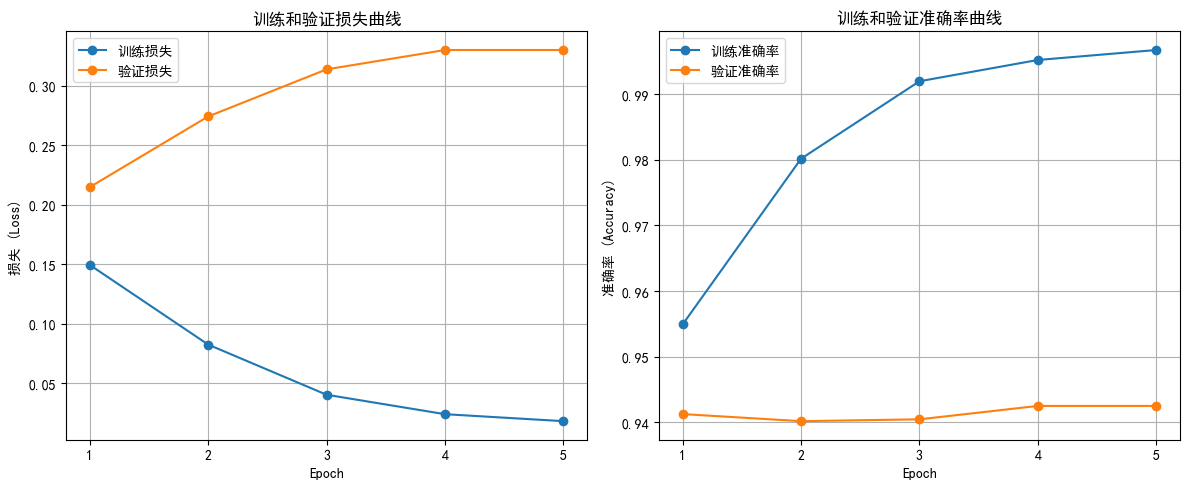

In [19]:
# 判断是否已有训练历史数据（确保训练过程已执行）
if history['train_loss']:
    plt.figure(figsize=(12, 5))  # 设置图像尺寸为宽12英寸，高5英寸

    # === 子图1：绘制训练与验证损失曲线 ===
    plt.subplot(1, 2, 1)  # 创建1行2列的子图结构，当前为第1个子图
    plt.plot(history['train_loss'], label='训练损失', marker='o')  # 绘制训练损失曲线
    plt.plot(history['val_loss'], label='验证损失', marker='o')  # 绘制验证损失曲线
    plt.title('训练和验证损失曲线')  # 图标题
    plt.xlabel('Epoch')            # x轴标签：轮数
    plt.ylabel('损失 (Loss)')      # y轴标签
    plt.xticks(                   # 设置x轴刻度为整数轮数（1开始）
        ticks=range(len(history['train_loss'])),
        labels=[str(i + 1) for i in range(len(history['train_loss']))]
    )
    plt.legend()                   # 显示图例
    plt.grid(True)                 # 显示网格，便于观察变化趋势

    # === 子图2：绘制训练与验证准确率曲线 ===
    plt.subplot(1, 2, 2)  # 当前为第2个子图
    plt.plot(history['train_acc'], label='训练准确率', marker='o')  # 训练准确率曲线
    plt.plot(history['val_acc'], label='验证准确率', marker='o')    # 验证准确率曲线
    plt.title('训练和验证准确率曲线')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (Accuracy)')
    plt.xticks(
        ticks=range(len(history['train_acc'])),
        labels=[str(i + 1) for i in range(len(history['train_acc']))]
    )
    plt.legend()
    plt.grid(True)

    # 自动调整子图间距，防止重叠
    plt.tight_layout()
    plt.show()  # 显示绘制结果
else:
    # 若未执行训练或训练失败，则跳过绘图
    print("没有训练历史数据可供可视化。")
    

训练曲线显示：

*   **损失曲线**: 训练损失整体随epoch增加而下降，但在训练损失持续下降时，验证损失却不断上升，初步判断模型可能出现了过拟合。
*   **准确率曲线**: 训练准确率和验证准确率整体来说都是随着epoch增加而上升。在这里训练准确率是持续上升的，但验证准确率中间出现了下降，最后是停滞，甚至有了一些下降趋势，这同样暗示模型出现了过拟合。

我们的目标是找到验证集上表现最好的模型，本次虽然找到了验证准确率最高的模型（验证集上准确率高达0.9425），但从可视化曲线可以看出，所得到的模型存在一定的过拟合风险。

## 6. 模型评估

### 6.1 在测试集上评估

训练过程结束后，我将使用验证集上表现最好的模型，在测试集上进行最终性能评估。该模型在训练阶段已保存在指定路径 `MODEL_SAVE_PATH` 中。下面的代码将加载该模型，并评估其在测试集上的平均损失和准确率。

In [22]:
# 检查是否存在已保存的最佳模型文件
if os.path.exists(MODEL_SAVE_PATH):
    print(f"\n加载最佳模型从 {MODEL_SAVE_PATH} ...")
    
    # === 重新构建模型结构，并加载已保存的权重 ===
    final_model = BertSentimentClassifier(BERT_MODEL_NAME, NUM_CLASSES)
    final_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))  # map_location 确保模型能在当前设备正确加载
    final_model.to(DEVICE)  # 将模型移动到 GPU 或 CPU
    final_model.eval()      # 设置为评估模式（禁用 Dropout）

    # === 使用测试集进行最终评估 ===
    if test_dataloader:
        n_test_examples = len(test_dataset)
        test_loss, test_acc, test_preds, test_true_labels = eval_model(
            final_model,
            test_dataloader,
            loss_fn,
            DEVICE,
            n_test_examples
        )
        print(f"\n最终模型在测试集上的表现:")
        print(f"  平均损失: {test_loss:.4f}")
        print(f"  准确率: {test_acc:.4f}")
    else:
        print("test_dataloader 为空，无法进行最终评估。")
        test_preds, test_true_labels = [], []  # 初始化为空列表，避免后续操作出错

# 如果保存的模型文件不存在，我将使用训练结束时保留在内存中的模型进行评估（如果可用）
else:
    print(f"未找到保存的模型: {MODEL_SAVE_PATH}。将使用训练结束时的模型进行评估（如果可用）。")
    
    # 检查当前内存中是否有可用的模型
    if 'model' in locals() and test_dataloader:
        final_model = model  # 直接使用内存中的模型
        final_model.eval()   # 设置为评估模式
        n_test_examples = len(test_dataset)
        
        # 在测试集上评估当前模型
        test_loss, test_acc, test_preds, test_true_labels = eval_model(
            final_model, test_dataloader, loss_fn, DEVICE, n_test_examples
        )
        print(f"\n当前模型在测试集上的表现:")
        print(f"  平均损失: {test_loss:.4f}")
        print(f"  准确率: {test_acc:.4f}")
    else:
        # 若无可用模型或测试数据，则无法完成评估
        print("没有可用的模型或测试数据加载器进行评估。")
        test_preds, test_true_labels = [], []  # 初始化为空列表，避免程序中断
        


加载最佳模型从 ./models\best_bert_sentiment_model.bin ...


评估中: 100%|██████████| 1563/1563 [01:52<00:00, 13.83batch/s, loss=0.000771]


最终模型在测试集上的表现:
  平均损失: 0.3300
  准确率: 0.9425


上述逻辑判断可确保模型评估具有鲁棒性——无论是否成功保存模型，都可以回退到当前训练的模型，从而顺利完成最终评估阶段。这一步是对训练成果的综合验证，也是整个情感分类流程的总结阶段。

### 6.2 混淆矩阵和分类报告

除了准确率这一整体性能指标之外，我们还可以通过 **混淆矩阵（Confusion Matrix）** 和 **分类报告（Classification Report）** 对模型进行更细致的评估。特别是在处理不平衡分类任务时，这些指标能帮助我们更全面地理解模型在不同类别上的表现。

#### 混淆矩阵

混淆矩阵展示了模型在各个真实类别与预测类别之间的交叉分布情况。对于二分类问题（如情感分析中的“积极”和“消极”），混淆矩阵形式如下：

|                | 预测为消极 (0)      | 预测为积极 (1)      |
| -------------- | ------------------- | ------------------- |
| 实际为消极 (0) | True Negative (TN)  | False Positive (FP) |
| 实际为积极 (1) | False Negative (FN) | True Positive (TP)  |

通过观察 TN、TP、FP、FN 的分布，可以识别模型是否偏向某一类、是否误报严重等问题。


#### 分类报告指标

基于混淆矩阵，可以计算出以下常用指标：

- **精确率（Precision）**：预测为正类中，有多少是真正的正类
   `Precision = TP / (TP + FP)`
- **召回率（Recall）**：实际正类中，有多少被正确预测为正类
   `Recall = TP / (TP + FN)`
- **F1 分数（F1-score）**：精确率与召回率的调和平均
   `F1 = 2 * (Precision * Recall) / (Precision + Recall)`
- **支持度（Support）**：每个类别中的真实样本数量

这些指标由 `sklearn.metrics.classification_report` 提供，能清晰地呈现模型在各类别上的表现。


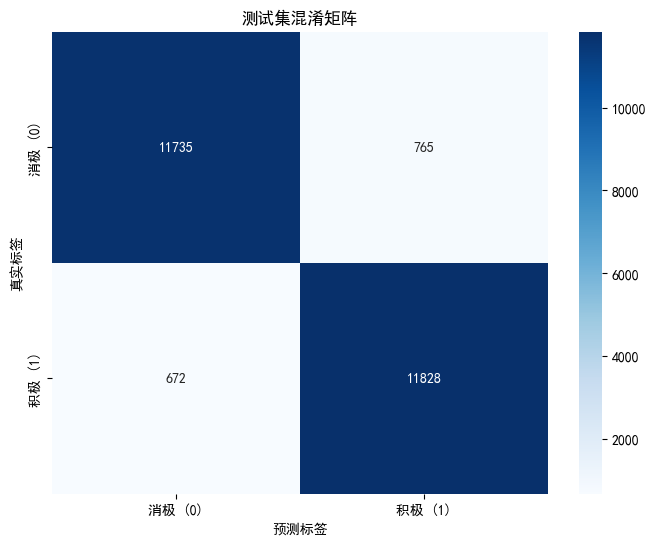


测试集分类报告:
              precision    recall  f1-score   support

      消极 (0)     0.9458    0.9388    0.9423     12500
      积极 (1)     0.9393    0.9462    0.9427     12500

    accuracy                         0.9425     25000
   macro avg     0.9425    0.9425    0.9425     25000
weighted avg     0.9425    0.9425    0.9425     25000


主要评估指标总结:
---------------------------------------------------------
类别              | 精确率        | 召回率        | F1分数       | 样本数       
---------------------------------------------------------
消极 (0)          | 0.9458     | 0.9388     | 0.9423     | 12500.0   
积极 (1)          | 0.9393     | 0.9462     | 0.9427     | 12500.0   
---------------------------------------------------------
Accuracy        |            |            | 0.9425     | 25000.0
Macro Avg       | 0.9425     | 0.9425     | 0.9425     | 25000.0
Weighted Avg    | 0.9425     | 0.9425     | 0.9425     | 25000.0
---------------------------------------------------------


In [23]:
# 确保测试集评估已执行，且有预测与真实标签数据
if test_preds and test_true_labels:
    class_names = ['消极 (0)', '积极 (1)']  # 二分类任务的类别标签

    # === 1. 绘制混淆矩阵 ===
    cm = confusion_matrix(test_true_labels, test_preds)  # 计算混淆矩阵
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,             # 在格子中显示数字
        fmt='d',                # 显示整数
        cmap='Blues',           # 设置配色
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('测试集混淆矩阵')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.show()

    # === 2. 输出详细分类报告（含精确率、召回率、F1分数） ===
    report = classification_report(
        test_true_labels,
        test_preds,
        target_names=class_names,
        digits=4
    )
    print("\n测试集分类报告:")
    print(report)

    # === 3. 提取报告字典以便格式化输出关键指标 ===
    report_dict = classification_report(
        test_true_labels,
        test_preds,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    # === 4. 表格形式展示主要评估指标 ===
    print("\n主要评估指标总结:")
    print("---------------------------------------------------------")
    print(f"{'类别':<15} | {'精确率':<10} | {'召回率':<10} | {'F1分数':<10} | {'样本数':<10}")
    print("---------------------------------------------------------")
    for name, metrics in report_dict.items():
        if name in class_names:  # 只显示实际类别的指标
            print(f"{name:<15} | {metrics['precision']:.4f}     | {metrics['recall']:.4f}     | {metrics['f1-score']:.4f}     | {metrics['support']:<10}")
    print("---------------------------------------------------------")

    # 显示整体准确率和平均指标
    print(f"{'Accuracy':<15} | {'':<10} | {'':<10} | {report_dict['accuracy']:.4f}     | {report_dict['macro avg']['support']}")
    print(f"{'Macro Avg':<15} | {report_dict['macro avg']['precision']:.4f}     | {report_dict['macro avg']['recall']:.4f}     | {report_dict['macro avg']['f1-score']:.4f}     | {report_dict['macro avg']['support']}")
    print(f"{'Weighted Avg':<15} | {report_dict['weighted avg']['precision']:.4f}     | {report_dict['weighted avg']['recall']:.4f}     | {report_dict['weighted avg']['f1-score']:.4f}     | {report_dict['weighted avg']['support']}")
    print("---------------------------------------------------------")
else:
    print("没有测试集的预测结果和真实标签，无法生成混淆矩阵和分类报告。")

#### 测试结果解读

- **总体表现**：
  模型在测试集上的准确率为 **94.25%**，说明其具有良好的泛化能力，能够有效区分积极与消极评论。

- **类别表现**：
  - “消极”类别的精确率略高，表明预测为消极的评论大多数是正确的；
  - “积极”类别的召回率更高，说明模型对积极评论的识别更为敏感；
  - 两类的 F1 分数均衡，表明模型在两个方向上的综合表现都很优秀。

- **平均指标**：
  宏平均和加权平均的各项指标均为 **0.9425**，进一步验证了模型分类性能的稳定性和平衡性。

综上所述，该模型在情感分析任务中具备较强的判别能力，预测结果稳定可靠。

## 7. 实例评估

为了更直观地了解模型在**真实场景中的应用效果**，我设计了一个小规模的实例预测实验。该实验使用训练好的模型对一些**人为编写的短句子**进行情感分类判断。

与之前的训练集和测试集不同，这些句子未参与任何训练过程，属于模型的“**零次样本测试**”（Zero-shot evaluation）。这种方式可以模拟模型在实际部署时对用户输入的反应情况。

在执行预测前，我们使用 softmax 函数将模型输出的 logits 转换为概率分布：

$softmax(xi)=exi∑jexj\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$

随后取最大概率对应的类别作为模型预测结果。下面是具体实现过程：

### 7.1 定义预测函数

In [25]:
def predict_sentiment(text, model, tokenizer, device, max_len=MAX_LEN):
    """
    对单条英文评论进行情感预测。

    参数:
    - text (str): 用户输入的评论句子。
    - model (nn.Module): 已训练好的情感分类模型。
    - tokenizer: HuggingFace 提供的 BERT 分词器。
    - device: 当前设备（如 'cuda' 或 'cpu'）。
    - max_len: 最大序列长度，超过部分会被截断。

    返回:
    - predicted_sentiment (str): 模型判断的情感类别（积极/消极）。
    - positive_probability (float): 属于“积极”类别的预测概率。
    """
    model.eval()  # 设置模型为评估模式，禁用 Dropout 等训练行为

    # 对输入句子进行编码（分词、ID 映射、填充与掩码生成）
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,     # 添加 [CLS] 和 [SEP] 标记
        max_length=max_len,
        padding='max_length',        # 填充到最大长度
        truncation=True,             # 超过最大长度的部分进行截断
        return_attention_mask=True,  # 返回 attention mask
        return_tensors='pt'          # 返回 PyTorch tensor 类型
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # 禁用梯度计算，节省显存和加速推理
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # 输出 logits: 维度为 [1, num_classes]，代表每一类的原始得分

        # 应用 softmax 将 logits 转换为概率分布
        probabilities = torch.softmax(outputs, dim=1)

        # 获取概率最大的类别索引
        _, prediction_idx = torch.max(outputs, dim=1)
        predicted_label_idx = prediction_idx.item()

    # 将类别索引映射为中文标签
    predicted_sentiment = '积极' if predicted_label_idx == 1 else '消极'
    positive_probability = probabilities[0, 1].item()  # 概率中第1类对应“积极”

    return predicted_sentiment, positive_probability

### 7.2 执行预测

In [26]:
# 如果模型未加载，则尝试从文件加载
if 'final_model' not in locals() or final_model is None:
    print("模型未加载，尝试从保存的文件加载...")
    if os.path.exists(MODEL_SAVE_PATH):
        final_model = BertSentimentClassifier(BERT_MODEL_NAME, NUM_CLASSES)
        final_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
        final_model.to(DEVICE)
        final_model.eval()
        print("模型加载成功。")
    else:
        print(f"错误: 无法加载模型 {MODEL_SAVE_PATH}，也无内存中的模型可用于实例评估。")
        final_model = None  # 明确设为空，避免后续使用报错


### 7.3 预测示例句子

In [27]:
if final_model:
    # 定义自定义的英文评论句子
    example_sentences = [
        "This movie was absolutely fantastic! The acting, storyline, and cinematography were all superb.",  # 预期：积极
        "I was really disappointed with this film. It was boring and the plot made no sense.",              # 预期：消极
        "The movie is okay, not great but not terrible either.",                                            # 预期：中性倾向，模型需强制分类
        "What a waste of time and money, I would not recommend this to anyone."                             # 预期：消极
    ]

    # 输出表头
    print("\n对示例句子进行情感预测:")
    print("----------------------------------------------------------------------")
    print(f"{'句子':<60} | {'预测情感':<10} | {'积极概率':<10}")
    print("----------------------------------------------------------------------")

    # 遍历每个句子，调用预测函数并输出结果
    for sentence in example_sentences:
        sentiment, pos_prob = predict_sentiment(sentence, final_model, tokenizer, DEVICE)
        print(f"{sentence[:58]:<60} | {sentiment:<10} | {pos_prob:.4f}")
    print("----------------------------------------------------------------------")
else:
    print("无法进行实例评估，因为模型未能成功加载或训练。")



对示例句子进行情感预测:
----------------------------------------------------------------------
句子                                                           | 预测情感       | 积极概率      
----------------------------------------------------------------------
This movie was absolutely fantastic! The acting, storyline   | 积极         | 0.9992
I was really disappointed with this film. It was boring an   | 消极         | 0.0002
The movie is okay, not great but not terrible either.        | 消极         | 0.1749
What a waste of time and money, I would not recommend this   | 消极         | 0.0003
----------------------------------------------------------------------


可以看出：

- 模型对于正负情绪明显的句子（如前两条）判断非常准确。
- 对于表达模糊或倾向中性的句子（如第三条），模型依然会做出强制性的分类预测。
- 这验证了**强二分类模型**的特点：即便输入模棱两可，也必须输出明确标签。


### 7.4 小结

这个实例评估环节很好地模拟了模型在实际应用中的推理能力。需要注意：

- 模型训练数据为电影评论，因此对非影评类文本的泛化能力可能下降；
- 若要部署到其他领域，还需要使用领域内数据进行微调（Fine-tuning）；
- 模型输出的概率值也可作为“预测置信度”来辅助实际决策，例如设定阈值拒判不确定样本。

通过这种方式，我们不仅能量化评估模型性能，还能直观体验其在真实输入下的预测行为。

## 8. 总结与展望

**总结**

本次作业成功地实现了一个基于BERT模型的情感识别系统，用于对IMDB电影评论进行二分类（积极/消极）。主要步骤包括：

1.  **环境配置**：搭建了包含PyTorch和HuggingFace Transformers库的深度学习环境。
2.  **数据处理**：
    *   自动下载并解压了IMDB数据集。
    *   实现了数据读取函数，将文本文件整理为评论列表和标签列表。
    *   使用BERT的`BertTokenizerFast`对文本进行了分词、编码、填充和截断，生成了模型所需的`input_ids`和`attention_mask`。
    *   创建了自定义的PyTorch `Dataset` 和 `DataLoader` 以便进行批处理训练。
3.  **模型构建**：
    *   定义了一个`BertSentimentClassifier`类，它在预训练的`bert-base-uncased`模型之上增加了一个Dropout层和一个线性分类层。
4.  **模型训练**：
    *   使用了交叉熵损失函数和AdamW优化器。
    *   实现了学习率预热和线性衰减的调度策略。
    *   编写了训练和评估循环，并在每个epoch后评估模型在验证集（此处用测试集）上的性能。
    *   保存了在验证集上准确率最高的模型。
    *   通过绘制损失和准确率曲线，可视化了训练过程。
5.  **模型评估**：
    *   加载了最佳模型，在测试集上报告了最终的准确率。
    *   生成了混淆矩阵和详细的分类报告（精确率、召回率、F1分数），对模型性能进行了全面分析。
6.  **实例预测**：
    *   实现了对新文本进行情感预测的功能，并展示了几个示例句子的预测结果。

从训练过程和最终评估结果来看，BERT模型在IMDB情感分析任务上表现出色，达到了较高的准确率（准确率高达94%）。

**展望**

尽管当前模型取得了不错的效果，但仍有许多可以探索和改进的方向：

1.  **超参数调优**：可以尝试不同的学习率、批大小、Dropout率、训练轮数，或使用更高级的超参数搜索方法（如Grid Search, Random Search, Bayesian Optimization）来找到最优配置。
2.  **更大的BERT模型**：可以尝试使用`bert-large-uncased`或其他更大的预训练模型，它们通常具有更强的表征能力，但计算开销也更大。
3.  **领域自适应预训练 (DAPT)** 或 **任务自适应预训练 (TAPT)**：在目标领域（如电影评论）或任务相关数据上对BERT进行进一步的预训练，可能提升其在特定任务上的性能。
4.  **不同的模型架构**：
    *   尝试其他Transformer变体，如RoBERTa, ALBERT, DistilBERT（更小更快的BERT版本）。
    *   对于RNN，可以构建双向LSTM或GRU网络，并结合预训练的词嵌入（如Word2Vec, GloVe, FastText）或直接使用BERT的词嵌入。
5.  **处理长文本**：对于超过BERT最大长度限制的评论，可以研究如Hierarchical Attention Networks, Longformer, BigBird等能处理更长序列的模型，或采用文本摘要、分段处理等策略。
6.  **集成学习**：结合多个不同模型（例如BERT和LSTM）的预测结果，可能会获得更鲁棒的性能。
7.  **错误分析**：仔细检查模型预测错误的样本，分析错误类型和原因，可能揭示模型的弱点和数据中的问题，为进一步改进提供线索。

总的来说，本次作业提供了一个完整的基于BERT进行文本情感分析的流程，为后续更复杂的NLP任务和模型研究打下了基础。